In [11]:
import sys
sys.path.append('../')
import os
import glob
import pandas as pd
import argparse
import configparser
import numpy as np
import torch
import matplotlib
matplotlib.use('tkagg')
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict

from model import *
from lib.preprocessing import *
from lib.dataloading import *
from lib.loss_functions import *
from lib.evaluation import *
from torchvision import transforms
import torchvision.models as models
from torch import optim, nn

In [2]:
def tensor2numpy(tensor):
    np_tensor = tensor.detach().numpy()    
    return np.rollaxis(np_tensor, 1 , 4)

def min_max(img):
    min = np.min(img)
    max = np.max(img)
    return (img - min)/(max - min)

In [3]:
generator =  CENet()

In [4]:
generator.load_state_dict(torch.load('../results/base-padding-dcm/epoch33.pth'))

<All keys matched successfully>

In [5]:
transform = get_transformer_norm()
dataset = SSIDataset(img_file = '../../../Data/SSI/ssi.csv', transform= transform['val'], inpaint = True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 2)
dataiter = iter(dataloader)

In [6]:
from torchvision.utils import make_grid

In [43]:
img, center, dcm = next(dataiter)

In [68]:
torch.cat([img[1:2,:,:,:], img[1:2,:,:,:]]).size()

torch.Size([2, 3, 256, 400])

In [67]:
img.size()

torch.Size([2, 3, 256, 400])

In [70]:
class ImageSmapler(object):
    def __init__(self, max_images = 64, sample_p = 0.1):
        self.n_images = 0
        self.max_images = max_images
        self.image_tensors = []
        self.pred_tensors = []
        
    def sample(self, imgs, centers, pred_centers):
        n_batchs = imgs.size()[0]
        for i in range(n_batchs):
            if np.random.uniform(0,1) < sample_p and self.n_images < self.max_images:
                true = self.padding_centers(imgs[i:i+1, :, : ,:], centers[i:i+1, :, : ,:])
                pred = self.padding_centers(imgs[i:i+1, :, : ,:], pred_centers[i:i+1, :, : ,:])
                
                self.image_tensors.append(true)
                self.pred_tensors.append(pred)                
                self.n_images += 1                                
    def make_grid(self):
        true = torch.cat(self.image_tensors)
        true = make_grid(true, normalize= True, scale_each = True)
        
        pred = torch.cat(self.pred_tensors)
        pred = make_grid(pred, normalize= True, scale_each = True)
        return true, pred
        
    def padding_center(self, imgs, centers):
        new_img = imgs.clone()
        new_img[:,:,64:192, 100:300] = centers
        return new_img        
        

In [44]:
img_np = tensor2numpy(img)
img_np = min_max(img_np)

In [45]:
img_np = tensor2numpy(img)
img_np = min_max(img_np)

center_np = tensor2numpy(center)
center_np = min_max(center_np)

In [46]:
pred_centers = generator(img)  
pred_center_np = tensor2numpy(pred_centers)
pred_center_np = min_max(pred_center_np)

In [47]:
ori_img = img_np[0].copy()
pred_img = img_np[0].copy()
h,w = ori_img.shape[0], ori_img.shape[1]

ori_img[h//4:(h*3//4), w//4:(w*3//4),:] = center_np[0]
pred_img[h//4:(h*3//4), w//4:(w*3//4),:] = pred_center_np[0]

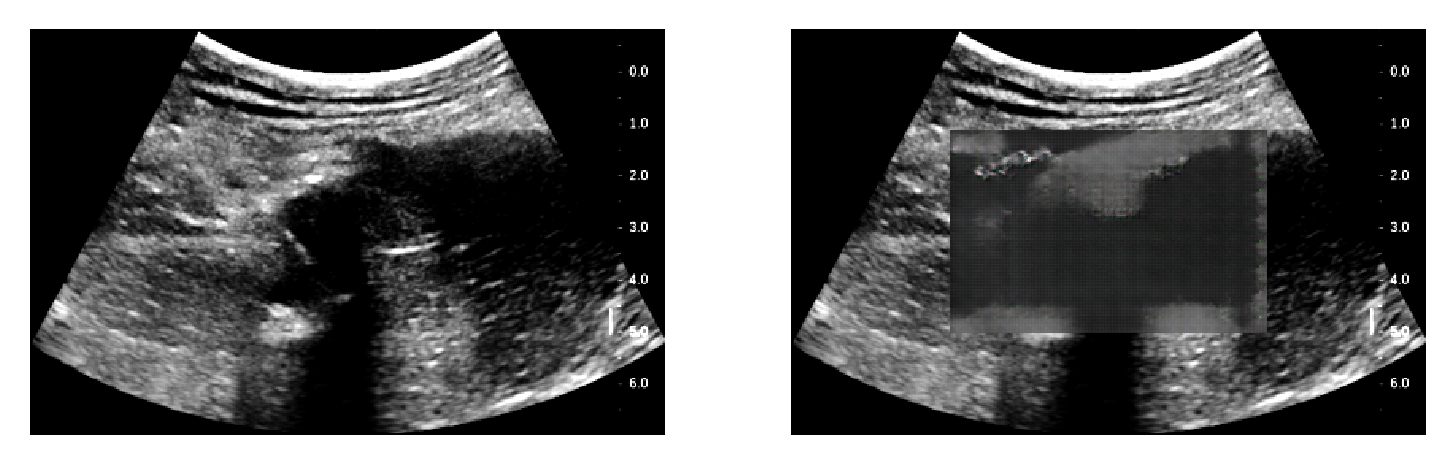

In [48]:
fig, axes = plt.subplots(ncols=2, dpi = 300)
axes[0].imshow(ori_img)
axes[1].imshow(pred_img)
[ax.set_axis_off() for ax in axes]
plt.show()